# Alexa Reviews Sentiment Analysis

In this project we will try to perform a sentiment analysis on Amazon's Alexa reviews data set.This dataset consists of a nearly 3000 Amazon customer reviews (input text), star ratings, date of review, variant and feedback of various amazon Alexa products like Alexa Echo, Echo dots, Alexa Firesticks etc.  
  
We will use following data set:  
https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews/data

## Naive Bayes

To perform sentiment analysis we will use Naive Bayes alghoritm. Naive Bayes is a probabilistic machine learning algorithm based on Bayes' theorem. It is commonly used for classification tasks, including text classification, spam filtering, and sentiment analysis. Despite its simplicity and "naive" assumptions, Naive Bayes often performs well in practice.  

The algorithm is grounded in Bayes' theorem, which describes the probability of an event based on prior knowledge of conditions that might be related to the event:   
 
$$ P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)} $$

Naive Bayes makes a "naive" assumption that the features used to describe an input instance are conditionally independent given the class label. In another worlds: we assume that features presence (words or phrases) is independent from each other. This simplifies the calculations, making the algorithm computationally efficient.  
  
To classify instance, Naive Bayes calculates the probability of each class given the observed features and selects the class with the highest probability.


In [1]:
import os
import re
import string
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Load Data

In [2]:
relative_path = 'amazon_alexa.tsv'
path = os.path.join(os.getcwd(),relative_path)

df = pd.read_csv(relative_path, sep='\t')

## Inspect data

In [3]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
df.shape

(3150, 5)

In [5]:
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

## Preprocessing

In [6]:
condition = pd.isnull(df['verified_reviews'])

df.drop(df[condition].index, axis=0, inplace=True)

In [7]:
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [8]:
df.drop(['date', 'variation'], axis=1, inplace=True)

In [9]:
df['length'] = df['verified_reviews'].apply(len)

We will change all letters to lowe case

In [10]:
df['verified_reviews'] = df['verified_reviews'].apply(lambda x: x.lower())

In [11]:
df.head()

,rating,verified_reviews,feedback,length
0,5,love my echo!,1,13
1,5,loved it!,1,9
2,4,"sometimes while playing a game, you can answer...",1,195
3,5,i have had a lot of fun with this thing. my 4 ...,1,172
4,5,music,1,5


Now we will erase stopwords. 

Stop words are commonly used words in a language that are generally filtered out or ignored during natural language processing (NLP) and text analysis. These words are often the most frequent and don't carry significant meaning by themselves. Including them in analysis or machine learning tasks can add noise to the data and may not contribute much to understanding the content.

Stop words can vary depending on the specific task or context, but common stop words in English include words like "the," "and," "is," "in," "to," "of," etc.

In [12]:
stopwords_file_path = "/Users/mjg/Desktop/CODING/6. CV/9. Naive Bayes/stopwords-en.txt"

# Read the stopwords from the file
with open(stopwords_file_path, 'r') as file:
    stopwords_list = [line.strip() for line in file]

# Create a set of stopwords
stopwords_set = set(stopwords_list)

# a set of words withot stop words
remove_words = lambda x:' '.join([word for word in x.split() if word not in stopwords_set])

# update df
df['transformed_reviews'] = df['verified_reviews'].apply(remove_words)



# punctuation
punctuation_list = ['!','.',',','?']
remove_punctuation = lambda x: ''.join([char if char not in punctuation_list else '' for char in x])

# update df
df['transformed_reviews'] = df['transformed_reviews'].apply(remove_punctuation)




In [13]:
df.head(10)

,rating,verified_reviews,feedback,length,transformed_reviews
0,5,love my echo!,1,13,love echo
1,5,loved it!,1,9,loved
2,4,"sometimes while playing a game, you can answer...",1,195,playing game answer question correctly alexa w...
3,5,i have had a lot of fun with this thing. my 4 ...,1,172,lot fun thing 4 yr learns dinosaurs control li...
4,5,music,1,5,music
5,5,i received the echo as a gift. i needed anothe...,1,172,received echo gift bluetooth play music easily...
6,3,"without having a cellphone, i cannot use many ...",1,365,cellphone features ipad use alarm deaf hear al...
7,5,i think this is the 5th one i've purchased. i'...,1,221,5th purchased house features offer specifily p...
8,5,looks great,1,11,
9,5,love it! i’ve listened to songs i haven’t hear...,1,114,love i’ve listened songs haven’t heard childho...


## EDA

In [14]:
words_list = [word for line in df['transformed_reviews'] for word in line.split()]

word_counts = Counter(words_list).most_common(50)
words_df = pd.DataFrame(word_counts)
words_df.columns =['word','frq']
words_df.head(10)

,word,frq
0,love,950
1,echo,821
2,alexa,576
3,music,522
4,it,416
5,easy,337
6,sound,331
7,set,295
8,dot,276
9,amazon,251


In [15]:
one_list = df['transformed_reviews'].tolist()
len(one_list)

one_line = " ".join(one_list)

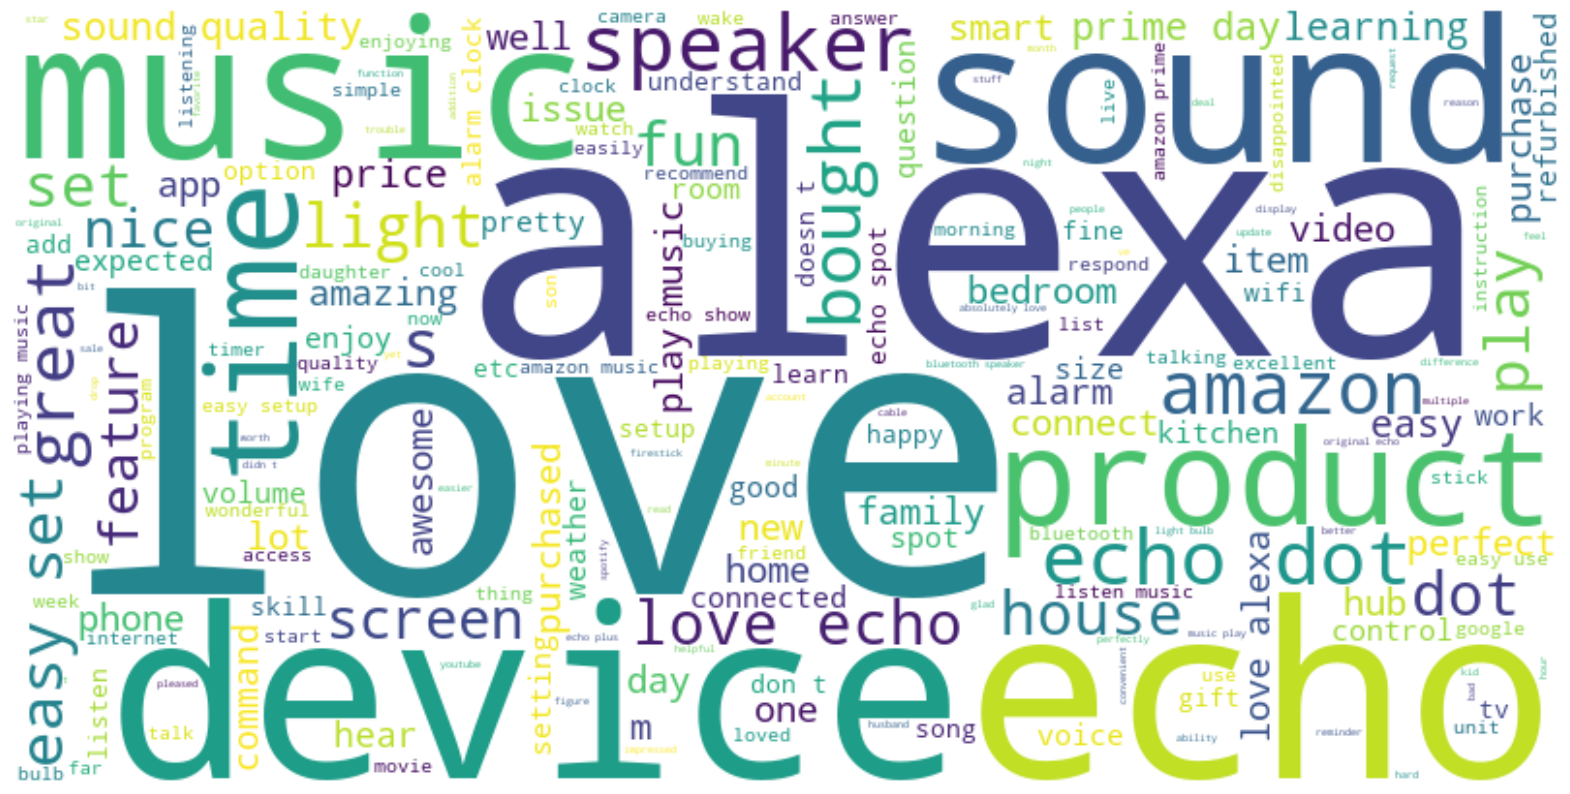

In [16]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', contour_color='black').generate(one_line)

# Display the WordCloud using matplotlib
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [17]:
df['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

/var/folders/l_/sd90yz351sn2j7ttw4wtv_7h0000gn/T/ipykernel_2042/3878348677.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')  # Create the bar plot


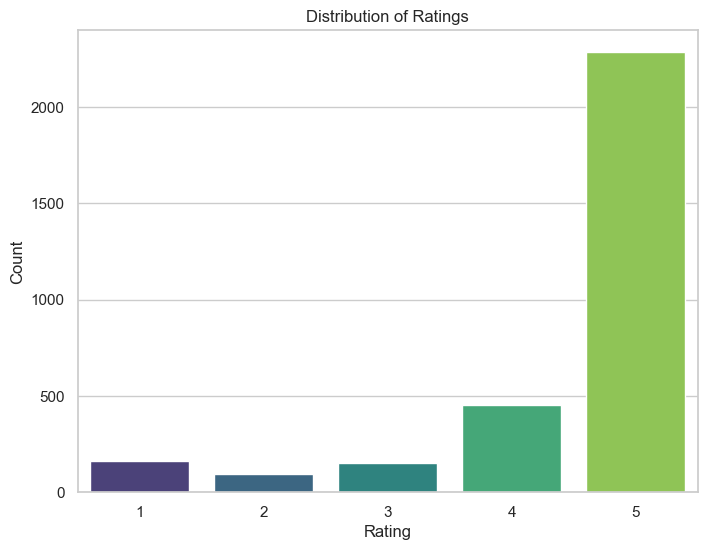

In [18]:
sns.set(style="whitegrid")  # Optional: Set the style of the plot
plt.figure(figsize=(8, 6))  # Optional: Set the size of the plot

sns.countplot(x='rating', data=df, palette='viridis')  # Create the bar plot

plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.show()

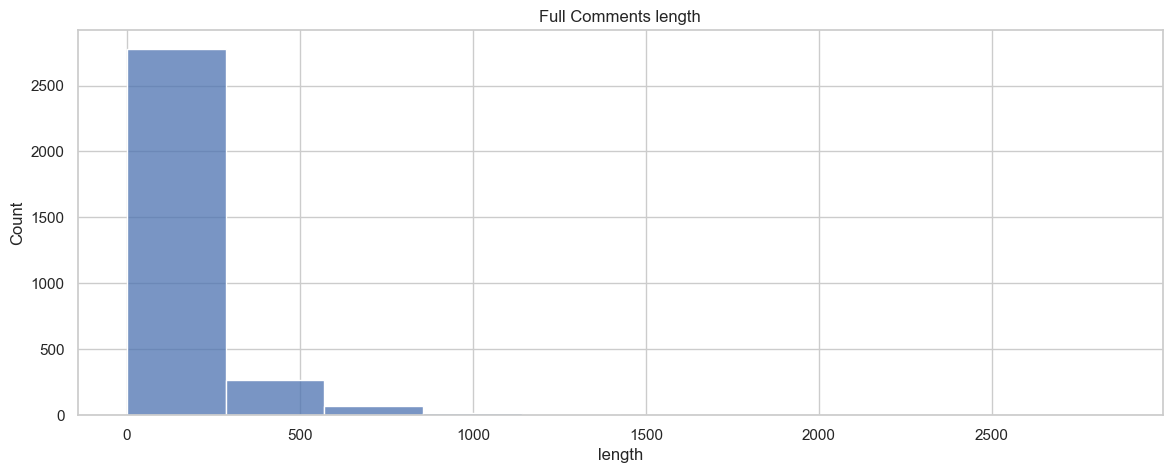

In [19]:
plt.figure(figsize=(14, 5))
sns.histplot(data=df,
             x="length",
             bins=10
            )

plt.title("Full Comments length")
plt.show()

## Tokenize and count vectorization

In sentiment analysis, tokenization and count vectorization are essential preprocessing steps to convert raw text data into a format that can be fed into machine learning models for analysis.  

**Tokenization** is the process of breaking down a text into smaller units called tokens. These tokens can be words, phrases, or other meaningful elements. Tokenization is crucial for transforming the continuous text into a structured format that can be analyzed. It allows a machine learning model to understand and process individual components of the text.

**Count vectorization** involves representing a document as a vector, where each element of the vector corresponds to the count of a particular word in the document. Count vectorization transforms the tokenized words into numerical features, creating a numerical representation of the text. It's often used to convert text data into a format suitable for machine learning algorithms.

In [20]:
vectorizer = CountVectorizer(analyzer = 'word')
vector = vectorizer.fit_transform(df['transformed_reviews'])

In [21]:
vector.shape

(3149, 4003)

In [22]:
X = pd.DataFrame(vector.toarray())
y = df['feedback']

In [23]:
X.shape

(3149, 4003)

In [24]:
y.shape

(3149,)

## Build model

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = MultinomialNB()

fit = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

## Evaluate model

In [26]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display the evaluation metrics
print(f'Accuracy: {accuracy}')
print('\nConfusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(class_report)

Accuracy: 0.9121693121693122

Confusion Matrix:
[[ 27  65]
 [ 18 835]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.29      0.39        92
           1       0.93      0.98      0.95       853

    accuracy                           0.91       945
   macro avg       0.76      0.64      0.67       945
weighted avg       0.90      0.91      0.90       945

